#### The purpose of this notebook is to prepare the data and split them into train and test

In [257]:
import numpy as np
import pandas as pd
import math
import random
from collections import Counter
import string

#NLP word learning packages
from glove import Corpus, Glove
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

#for plot
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zijun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zijun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [280]:
import pickle
from IPython.display import HTML
from IPython.display import display

In [3]:
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
#import the merged data
filename = "GameData.csv"
df = pd.read_csv(filename,encoding = "mac_roman",sep='\t')

In [5]:
df.head(5)

,Unnamed: 0,new-price,sales-volume,release-year,genres,name,slug,rating,developers,platforms,tags,match
0,NaN,<lambda>,sum,<lambda>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,product-name-slug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-30-great-games--family-party,7.88,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,Wii,[party],True
3,007--agent-under-fire,12.43,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...","Xbox,GameCube,PlayStation 2","Multiplayer,Singleplayer",True
4,007--everything-or-nothing,9.987066800602712,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores","PlayStation 2,Game Boy Advance,Xbox,GameCube","Multiplayer,Singleplayer,cooperativeplay",True


In [6]:
#get rid of the first 2 rows
df = df.iloc[2:]

In [7]:
df = df.rename(columns={"Unnamed: 0": "product-name-slug"})

In [8]:
df = df.reset_index()

In [9]:
df.head(3)

,index,product-name-slug,new-price,sales-volume,release-year,genres,name,slug,rating,developers,platforms,tags,match
0,2,-30-great-games--family-party,7.88,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,Wii,[party],True
1,3,007--agent-under-fire,12.43,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...","Xbox,GameCube,PlayStation 2","Multiplayer,Singleplayer",True
2,4,007--everything-or-nothing,9.987066800602712,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores","PlayStation 2,Game Boy Advance,Xbox,GameCube","Multiplayer,Singleplayer,cooperativeplay",True


In [10]:
df["match"].value_counts()

True    11367
Name: match, dtype: int64

In [11]:
#take the lines with match = True, i.e., games that can be found on rawg
df_game = df[df["match"]==True]

In [12]:
genres_series = []

In [13]:
#create a function to clean genres, platforms and developers
def clean_format(label,df_set):
    result = []
    for index,row in df_set.iterrows():
        data_label = row[label]
        if isinstance(data_label ,float):
            result.append("NA")
        else:
            if data_label[0] == "[":
                #if it's a single string and starts with "["
                temp = data_label[1:-1]
                result.append(temp.lower())
            else:
                #if the string is separated by commas
                temp = data_label.split(",")
                #transform to lower cases
                temp_lower = [x.lower() for x in temp]
                result.extend(temp_lower)
    return result

In [14]:
#clean genres
genres_output = clean_format("genres",df)

In [15]:
genres_output_unique = set(genres_output)

In [16]:
genres_output_unique 

{'NA',
 'action',
 'adventure',
 'arcade',
 'board games',
 'board-games',
 'card',
 'casual',
 'educational',
 'family',
 'fighting',
 'indie',
 'massively multiplayer',
 'massively-multiplayer',
 'platformer',
 'puzzle',
 'racing',
 'role-playing-games-rpg',
 'rpg',
 'shooter',
 'simulation',
 'sports',
 'strategy'}

In [17]:
#clean developers
developers_output = clean_format("developers",df)

In [18]:
developers_output_unique = set(developers_output)

In [19]:
#clean platforms
platforms_output = clean_format("platforms",df)

In [20]:
platforms_output_unique = set(platforms_output)

In [21]:
len(set(platforms_output))

50

In [22]:
#clean tags
tags_output = clean_format("tags",df)

In [23]:
tags_output_unique = set(tags_output)

In [24]:
len(set(tags_output)) 

707

Several feature engineering:
1. Change release-year to age
2. For genres and platforms, Iwill extract unique values for each case and make them binary features(one-hot coding)
3. For tags and developers, I will extract specific values for each case in the most common ones, put the others into either "Others" and make them binary features(one-hot coding)
4. Change NaN to "NA" as a stand-alone value
5. Normalization if necessary
6. Word learning on game names using GloVe and tfidf

In [25]:
#change the release-year to age
df["age"] = 2019 - df["release-year"].astype(float)

In [26]:
#filter out the negative age
df = df[df["age"]>=0]

In [27]:
genres_output_unique

{'NA',
 'action',
 'adventure',
 'arcade',
 'board games',
 'board-games',
 'card',
 'casual',
 'educational',
 'family',
 'fighting',
 'indie',
 'massively multiplayer',
 'massively-multiplayer',
 'platformer',
 'puzzle',
 'racing',
 'role-playing-games-rpg',
 'rpg',
 'shooter',
 'simulation',
 'sports',
 'strategy'}

In [28]:
#make a copy of df
df_inuse = df.copy()

In [29]:
#clean genres and platforms
#first clean some typo errors
#clearly, board-games and board games are the same, and massively multiplayer and massively-multiplayer are the same
#let's keep 'board-games' and 'massively-multiplayer' 'massively multiplayer'
genres_output_unique.remove('board games')
genres_output_unique.remove('massively multiplayer')

In [30]:
#make each genre a binary feature
genres_features_label = list(genres_output_unique)

In [31]:
genres_features_label = ["genre-" + x for x in genres_features_label]

In [32]:
#example
genres_features_label[:5] 

['genre-action',
 'genre-casual',
 'genre-family',
 'genre-sports',
 'genre-strategy']

In [33]:
#and prepare them binary features
#create placeholder in df_inuse
for title in genres_features_label:
    df_inuse[title] = 0

In [34]:
df_inuse.head(5)

,index,product-name-slug,new-price,sales-volume,release-year,genres,name,slug,rating,developers,...,genre-rpg,genre-shooter,genre-massively-multiplayer,genre-board-games,genre-fighting,genre-platformer,genre-indie,genre-educational,genre-card,genre-adventure
0,2,-30-great-games--family-party,7.88,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,...,0,0,0,0,0,0,0,0,0,0
1,3,007--agent-under-fire,12.43,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...",...,0,0,0,0,0,0,0,0,0,0
2,4,007--everything-or-nothing,9.987066800602712,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores",...,0,0,0,0,0,0,0,0,0,0
3,5,007--from-russia-with-love,8.94,99,2005.0,[action],James Bond 007: From Russia with Love,james-bond-007-from-russia-with-love,3.91,"Rebellion,Visceral Games,Electronic Arts Redwo...",...,0,0,0,0,0,0,0,0,0,0
4,6,007--nightfire,38.1529028714891,255,2003.0,"Action,Shooter",James Bond 007: NightFire,james-bond-007-nightfire,3.93,[gearbox-software],...,0,0,0,0,0,0,0,0,0,0


In [35]:
#populate genre features

def clean_format_features(label,df_set,label_type):
    for index,row in df_set.iterrows():
        data_label = row[label]
        if isinstance(data_label ,float):
            df_set.loc[index,label_type+ "-"+"NA"] = 1
        else:
            if data_label[0] == "[":
                #if it's a single string and starts with "["
                temp = data_label[1:-1]
                #modify 2 genres,only works when it's populating genres
                if temp == "board games":
                    temp = "board-games"
                elif temp == "massively multiplayer":
                    temp = "massively-multiplayer"
                df_set.loc[index,label_type+ "-"+temp] = 1
            else:
                #if the string is separated by commas and has multiple genres
                temp = data_label.split(",")
                #transform to lower cases
                temp_lower = [x.lower() for x in temp]

                for tt in temp_lower:
                    if tt == "board games":
                        tt = "board-games"
                    elif tt == "massively multiplayer":
                        tt = "massively-multiplayer"
                    df_set.loc[index,label_type+ "-"+tt] = 1
    return df_set

In [36]:
#populate genres
df_genres_cleaned = clean_format_features("genres",df_inuse,"genre")

In [37]:
#example
df_genres_cleaned.iloc[3] 

index                                                                           5
product-name-slug                                      007--from-russia-with-love
new-price                                                                    8.94
sales-volume                                                                   99
release-year                                                               2005.0
genres                                                                   [action]
name                                        James Bond 007: From Russia with Love
slug                                         james-bond-007-from-russia-with-love
rating                                                                       3.91
developers                      Rebellion,Visceral Games,Electronic Arts Redwo...
platforms                                         GameCube,PlayStation 2,PSP,Xbox
tags                                                     Multiplayer,Singleplayer
match           

In [38]:
#clean the platforms in the same fashion
platforms_output_unique

{'3do',
 'NA',
 'android',
 'apple ii',
 'atari 2600',
 'atari 5200',
 'atari 7800',
 'atari 8-bit',
 'atari flashback',
 'atari lynx',
 'atari st',
 'atari xegs',
 'classic macintosh',
 'commodore / amiga',
 'dreamcast',
 'game boy',
 'game boy advance',
 'game boy color',
 'game gear',
 'gamecube',
 'genesis',
 'ios',
 'jaguar',
 'linux',
 'macos',
 'neo geo',
 'nes',
 'nintendo 3ds',
 'nintendo 64',
 'nintendo ds',
 'nintendo dsi',
 'nintendo switch',
 'pc',
 'playstation',
 'playstation 2',
 'playstation 3',
 'playstation 4',
 'ps vita',
 'psp',
 'sega 32x',
 'sega cd',
 'sega master system',
 'sega saturn',
 'snes',
 'web',
 'wii',
 'wii u',
 'xbox',
 'xbox 360',
 'xbox one'}

In [39]:
platforms_features_label = list(platforms_output_unique)

In [40]:
platforms_features_label = ["platform-" + x for x in platforms_features_label]

In [41]:
for title in platforms_features_label:
    df_genres_cleaned[title] = 0

In [42]:
df_genres_cleaned.iloc[3]

index                                                                           5
product-name-slug                                      007--from-russia-with-love
new-price                                                                    8.94
sales-volume                                                                   99
release-year                                                               2005.0
genres                                                                   [action]
name                                        James Bond 007: From Russia with Love
slug                                         james-bond-007-from-russia-with-love
rating                                                                       3.91
developers                      Rebellion,Visceral Games,Electronic Arts Redwo...
platforms                                         GameCube,PlayStation 2,PSP,Xbox
tags                                                     Multiplayer,Singleplayer
match           

In [43]:
#populate the platform feature
df_platform_cleaned = clean_format_features("platforms",df_genres_cleaned,"platform")

In [44]:
df_platform_cleaned.iloc[3]

index                                                                           5
product-name-slug                                      007--from-russia-with-love
new-price                                                                    8.94
sales-volume                                                                   99
release-year                                                               2005.0
genres                                                                   [action]
name                                        James Bond 007: From Russia with Love
slug                                         james-bond-007-from-russia-with-love
rating                                                                       3.91
developers                      Rebellion,Visceral Games,Electronic Arts Redwo...
platforms                                         GameCube,PlayStation 2,PSP,Xbox
tags                                                     Multiplayer,Singleplayer
match           

In [45]:
#now populate developers: pick the most common 50 and put others in "others"
#example of the developers
developers_output[:5] 

['NA',
 'electronic arts',
 'visceral games',
 'electronic arts redwood shores',
 'griptonite games']

In [46]:
#get the top 50
developers_output_count = Counter(developers_output)
developers_output_top50 = developers_output_count.most_common(50)
developers_output_top50

[('NA', 12677),
 ('nintendo', 267),
 ('sega', 260),
 ('sony interactive entertainment', 241),
 ('capcom', 238),
 (' inc.', 224),
 ('ubisoft', 210),
 ('electronic arts', 197),
 ('konami-digital-entertainment', 192),
 ('activision', 122),
 ('vicarious visions', 117),
 ('bandai namco entertainment america inc.', 96),
 ('warner bros. interactive', 96),
 ('beenox', 89),
 ('ubisoft montreal', 86),
 (' ltd.', 84),
 ('feral interactive', 84),
 ('square-enix', 84),
 ('electronic arts canada', 81),
 ('atlus', 81),
 ('n-space', 79),
 ('capcom u.s.a.', 77),
 ('konami digital entertainment', 75),
 ('nis america inc.', 72),
 ('sony-interactive-entertainment', 72),
 ("traveller's tales", 67),
 ('square enix', 67),
 ('rare', 63),
 ('aspyr media', 62),
 ('ea-canada', 61),
 ('namco', 57),
 ('atari', 57),
 ('2k', 57),
 ('thq nordic', 56),
 ('tecmo koei america', 55),
 ('rare ltd.', 52),
 ('codemasters', 50),
 ('aksys games', 47),
 ('natsume', 47),
 ('eurocom', 45),
 ('electronic-arts', 45),
 ('midway gam

In [47]:
developers_output_top50_list = [x[0] for x in developers_output_top50]

In [48]:
#need to add others
developers_output_top50_list.append("Others")

In [49]:
#these are the top 50 developers + NA + Others
developers_output_top50_list

['NA',
 'nintendo',
 'sega',
 'sony interactive entertainment',
 'capcom',
 ' inc.',
 'ubisoft',
 'electronic arts',
 'konami-digital-entertainment',
 'activision',
 'vicarious visions',
 'bandai namco entertainment america inc.',
 'warner bros. interactive',
 'beenox',
 'ubisoft montreal',
 ' ltd.',
 'feral interactive',
 'square-enix',
 'electronic arts canada',
 'atlus',
 'n-space',
 'capcom u.s.a.',
 'konami digital entertainment',
 'nis america inc.',
 'sony-interactive-entertainment',
 "traveller's tales",
 'square enix',
 'rare',
 'aspyr media',
 'ea-canada',
 'namco',
 'atari',
 '2k',
 'thq nordic',
 'tecmo koei america',
 'rare ltd.',
 'codemasters',
 'aksys games',
 'natsume',
 'eurocom',
 'electronic-arts',
 'midway games',
 'bethesda softworks',
 'sonic team',
 'rebellion',
 'thq',
 'bandai namco entertainment',
 'fromsoftware',
 'tose',
 'arc system works',
 'Others']

In [50]:
#make it a dictionary so that it's faster to search in the process of feature engineering
developers_output_top50_dict = {}
for x in developers_output_top50_list:
    developers_output_top50_dict[x] = "developer-"+x

In [51]:
developers_output_top50_dict 

{'NA': 'developer-NA',
 'nintendo': 'developer-nintendo',
 'sega': 'developer-sega',
 'sony interactive entertainment': 'developer-sony interactive entertainment',
 'capcom': 'developer-capcom',
 ' inc.': 'developer- inc.',
 'ubisoft': 'developer-ubisoft',
 'electronic arts': 'developer-electronic arts',
 'konami-digital-entertainment': 'developer-konami-digital-entertainment',
 'activision': 'developer-activision',
 'vicarious visions': 'developer-vicarious visions',
 'bandai namco entertainment america inc.': 'developer-bandai namco entertainment america inc.',
 'warner bros. interactive': 'developer-warner bros. interactive',
 'beenox': 'developer-beenox',
 'ubisoft montreal': 'developer-ubisoft montreal',
 ' ltd.': 'developer- ltd.',
 'feral interactive': 'developer-feral interactive',
 'square-enix': 'developer-square-enix',
 'electronic arts canada': 'developer-electronic arts canada',
 'atlus': 'developer-atlus',
 'n-space': 'developer-n-space',
 'capcom u.s.a.': 'developer-capc

In [52]:
#modify the function earlier to fit developers and tags
def clean_format_features_2(label,df_set,label_dict):
    for index,row in df_set.iterrows():
        data_label = row[label]
        if isinstance(data_label ,float):
            #it's NA
            df_set.loc[index,label_dict["NA"]] = 1
        else:
            if data_label[0] == "[":
                #if it's a single string and starts with "["
                #means there's only one item -> we take the string without "[]"
                temp = data_label[1:-1]
                #modify if the item is not in the dictionary (not in the top50 or 25 depending on the label)
                if temp in label_dict:
                    df_set.loc[index,label_dict[temp]] = 1
                else:
                    #other developers
                    temp = "Others"
                    df_set.loc[index,label_dict[temp]] = 1
            else:
                #if the string is separated by commas and has multiple items
                temp = data_label.split(",")
                #transform to lower cases
                temp_lower = [x.lower() for x in temp]

                for tt in temp_lower:
                    if tt in label_dict:
                        df_set.loc[index,label_dict[tt]] = 1
                    else:
                        tt = "Others"
                        df_set.loc[index,label_dict[tt]] = 1
                    
    return df_set

In [53]:
#make a copy of the dataframe we worked on so far
df_new = df_platform_cleaned

In [54]:
#pre-populate the dataset with zeros
for title in developers_output_top50_dict.items():
    df_new[title[1]] = 0

In [55]:
df_new.head(5)

,index,product-name-slug,new-price,sales-volume,release-year,genres,name,slug,rating,developers,...,developer-midway games,developer-bethesda softworks,developer-sonic team,developer-rebellion,developer-thq,developer-bandai namco entertainment,developer-fromsoftware,developer-tose,developer-arc system works,developer-Others
0,2,-30-great-games--family-party,7.88,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,...,0,0,0,0,0,0,0,0,0,0
1,3,007--agent-under-fire,12.43,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...",...,0,0,0,0,0,0,0,0,0,0
2,4,007--everything-or-nothing,9.987066800602712,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores",...,0,0,0,0,0,0,0,0,0,0
3,5,007--from-russia-with-love,8.94,99,2005.0,[action],James Bond 007: From Russia with Love,james-bond-007-from-russia-with-love,3.91,"Rebellion,Visceral Games,Electronic Arts Redwo...",...,0,0,0,0,0,0,0,0,0,0
4,6,007--nightfire,38.1529028714891,255,2003.0,"Action,Shooter",James Bond 007: NightFire,james-bond-007-nightfire,3.93,[gearbox-software],...,0,0,0,0,0,0,0,0,0,0


In [56]:
#create features for developers
df_developers_cleaned = clean_format_features_2("developers",df_new,developers_output_top50_dict)

In [57]:
#example
df_developers_cleaned.loc[1,"developers"]

'Electronic Arts,Visceral Games,Electronic Arts Redwood Shores'

In [58]:
#example
df_developers_cleaned.loc[1,"developer-electronic arts"]

1

In [59]:
#save a copy
df_new = df_developers_cleaned

In [60]:
#clean tags in the same way (top 25 tags)
tags_output_count = Counter(tags_output)
tags_output_top25 = tags_output_count.most_common(25)
tags_output_top25_list = [x[0] for x in tags_output_top25]
tags_output_top25_list.append("Others")


tags_output_top25_dict = {}
for x in tags_output_top25_list:
    tags_output_top25_dict[x] = "tag-"+x

In [61]:
tags_output_top25_dict

{'NA': 'tag-NA',
 'singleplayer': 'tag-singleplayer',
 'exclusive': 'tag-exclusive',
 'multiplayer': 'tag-multiplayer',
 'true exclusive': 'tag-true exclusive',
 'steam achievements': 'tag-steam achievements',
 'steam cloud': 'tag-steam cloud',
 'full controller support': 'tag-full controller support',
 'steam-trading-cards': 'tag-steam-trading-cards',
 'atmospheric': 'tag-atmospheric',
 'great soundtrack': 'tag-great soundtrack',
 'multi-player': 'tag-multi-player',
 'rpg': 'tag-rpg',
 'partial controller support': 'tag-partial controller support',
 'story rich': 'tag-story rich',
 'co-op': 'tag-co-op',
 'open world': 'tag-open world',
 'third person': 'tag-third person',
 'role-playing': 'tag-role-playing',
 'first-person': 'tag-first-person',
 'anime': 'tag-anime',
 'steam leaderboards': 'tag-steam leaderboards',
 'sci-fi': 'tag-sci-fi',
 'fantasy': 'tag-fantasy',
 'classic': 'tag-classic',
 'Others': 'tag-Others'}

In [62]:
#pre-populate the dataset with zeros
for title in tags_output_top25_dict.items():
    df_new[title[1]] = 0
    
df_new.head(5)

,index,product-name-slug,new-price,sales-volume,release-year,genres,name,slug,rating,developers,...,tag-open world,tag-third person,tag-role-playing,tag-first-person,tag-anime,tag-steam leaderboards,tag-sci-fi,tag-fantasy,tag-classic,tag-Others
0,2,-30-great-games--family-party,7.88,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,...,0,0,0,0,0,0,0,0,0,0
1,3,007--agent-under-fire,12.43,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...",...,0,0,0,0,0,0,0,0,0,0
2,4,007--everything-or-nothing,9.987066800602712,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores",...,0,0,0,0,0,0,0,0,0,0
3,5,007--from-russia-with-love,8.94,99,2005.0,[action],James Bond 007: From Russia with Love,james-bond-007-from-russia-with-love,3.91,"Rebellion,Visceral Games,Electronic Arts Redwo...",...,0,0,0,0,0,0,0,0,0,0
4,6,007--nightfire,38.1529028714891,255,2003.0,"Action,Shooter",James Bond 007: NightFire,james-bond-007-nightfire,3.93,[gearbox-software],...,0,0,0,0,0,0,0,0,0,0


In [63]:
#populate binary features on tags
df_tags_cleaned = clean_format_features_2("tags",df_new,tags_output_top25_dict)

In [64]:
#example
df_tags_cleaned.loc[1,"tags"]

'Multiplayer,Singleplayer'

##### Use GloVe Model to train game names

In [65]:
stop_words = set(stopwords.words('english')) 
len(stop_words)

179

In [66]:
#replace "-" with space in slug and every name would be a document. The corpus would be all the game titles.
df_new = df_tags_cleaned.copy()

In [67]:
len(df_new) 

22921

In [68]:
#We need to use "product-name-slug" as it has more information
#this information will be reflected in the word vectors

df_new["glove_name"] = df_new["product-name-slug"].str.replace("-"," ")

In [69]:
#get rid of all the punctuations

df_new["glove_name"] = df_new["glove_name"].str.translate(str.maketrans('', '', string.punctuation))

In [70]:
raw_lines = list(df_new["glove_name"])

In [71]:
raw_lines[:5]

[' 30 great games  family party',
 '007  agent under fire',
 '007  everything or nothing',
 '007  from russia with love',
 '007  nightfire']

In [72]:
lines = [str(x) if isinstance(x,float) else word_tokenize(x) for x in raw_lines]

In [73]:
lines[:5]

[['30', 'great', 'games', 'family', 'party'],
 ['007', 'agent', 'under', 'fire'],
 ['007', 'everything', 'or', 'nothing'],
 ['007', 'from', 'russia', 'with', 'love'],
 ['007', 'nightfire']]

In [74]:
#get rid of english stopwords
filtered_lines = []
for l in lines:
    temp = 0
    if l == 'nan':
        temp = ['nan']
    else:
        temp = [w for w in l if (w not in stop_words)]                  
    filtered_lines.append(temp)

In [75]:
filtered_lines[:5]

[['30', 'great', 'games', 'family', 'party'],
 ['007', 'agent', 'fire'],
 ['007', 'everything', 'nothing'],
 ['007', 'russia', 'love'],
 ['007', 'nightfire']]

In [76]:
#save filtred_lines
save_obj(filtered_lines,"filtered_lines_ver_2")

##### Check most common words (to double check if there's any residue punctuations)

In [77]:
flatten_lines =  [item for sublist in filtered_lines for item in sublist]
word_counter = Counter(flatten_lines)
word_counter.most_common(200)

[('2', 1524),
 ('edition', 1346),
 ('super', 618),
 ('3', 588),
 ('hits', 553),
 ('greatest', 509),
 ('world', 497),
 ('ii', 469),
 ('star', 334),
 ('limited', 313),
 ('collectors', 291),
 ('game', 257),
 ('box', 241),
 ('dragon', 241),
 ('force', 240),
 ('4', 236),
 ('wars', 235),
 ('battle', 233),
 ('pro', 217),
 ('collection', 212),
 ('soccer', 204),
 ('racing', 202),
 ('ultimate', 202),
 ('5', 198),
 ('mario', 194),
 ('adventure', 190),
 ('party', 188),
 ('man', 185),
 ('iii', 183),
 ('final', 182),
 ('football', 174),
 ('ninja', 174),
 ('pack', 165),
 ('challenge', 162),
 ('bundle', 162),
 ('nba', 161),
 ('games', 160),
 ('sports', 159),
 ('dark', 158),
 ('time', 157),
 ('dance', 157),
 ('war', 157),
 ('x', 156),
 ('1', 155),
 ('king', 155),
 ('vs', 154),
 ('championship', 153),
 ('fantasy', 153),
 ('baseball', 151),
 ('adventures', 151),
 ('golf', 148),
 ('ball', 148),
 ('power', 146),
 ('street', 145),
 ('dead', 142),
 ('quest', 139),
 ('team', 136),
 ('warriors', 134),
 ('metal

### Train corpus to generate word vectors

In [78]:
#now train the corpus
corpus = Corpus() 

In [79]:
corpus.fit(filtered_lines, window=10)

In [80]:
#word embedding of 50
glove = Glove(no_components=50, learning_rate=0.01)

In [81]:
glove.fit(corpus.matrix, epochs=100, no_threads=4, verbose=True)

Performing 100 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [82]:
glove.add_dictionary(corpus.dictionary)

In [83]:
glove.save('glove.model')

In [84]:
glove.dictionary['james']

29

### checking some nouns to see the performance

In [85]:
print(glove.word_vectors[glove.dictionary['james']])

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]


In [86]:
print(glove.most_similar('james'))

[('pond', 0.7085986497500207), ('burst', 0.6786504428360346), ('book', 0.6519728864166612), ('reverie', 0.6513098448726607)]


In [87]:
print(glove.most_similar('007'))

[('third', 0.7433553903021408), ('veronica', 0.7299431133293455), ('getaway', 0.7231398563539574), ('wrath', 0.717463489220497)]


In [88]:
print(glove.most_similar('kart'))

[('stars', 0.8310421748287459), ('bros', 0.8195845645259273), ('smash', 0.7103039511460456), ('f1', 0.709856126756457)]


In [89]:
print(glove.most_similar('assassins'))

[('creed', 0.9960528033447483), ('origins', 0.9304566378930905), ('legacy', 0.8288224939451014), ('unity', 0.7972232055947592)]


In [90]:
print(glove.most_similar('dragon'))

[('ball', 0.9987754809886535), ('z', 0.9967615481972905), ('budokai', 0.9776837526948976), ('quest', 0.9769386145577043)]


In [91]:
print(glove.most_similar('hits'))

[('greatest', 0.9986111219210837), ('platinum', 0.9914660406708127), ('arcades', 0.957060881477086), ('persona', 0.905429886637867)]


In [92]:
print(glove.most_similar('collectors'))

[('edition', 0.9991175415761346), ('limited', 0.9986324320590823), ('special', 0.9974338657429007), ('deluxe', 0.9961771720496433)]


In [93]:
#virtualize using t-SNE

%matplotlib inline

#function from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

def tsne_transform(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.dictionary:

        tokens.append(model.word_vectors[model.dictionary[word]])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=10)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    #return the PCA on 2 dimentions as well as their represented words
    return x,y,labels


In [94]:
#transform from a dimention of 50 to 2
x,y,labels_lst = tsne_transform(glove)

In [181]:
data_set=pd.DataFrame(list(zip(x,y,labels_lst)),columns=["x","y","labels"])

In [183]:
data_set.head(5)

,x,y,labels
0,-55.970562,-20.638620,30
1,-35.121662,49.451874,great
2,-83.795242,-37.634739,games
3,-96.925682,23.063656,family
4,93.232582,29.460453,party


In [102]:
#size of the decomposed vectors
full_size = len(x)
full_size

10934

In [176]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

In [267]:
#algorithm to show the graph
#2 modes: full picture without labels or a zoomed version with labels
def tsne_plot(x,y,labels,x_min,x_max,y_min,y_max,picname,num_points,zoom):
    plt.figure(figsize=(16, 16)) 

    subdata = data_set.iloc[:num_points]
    
    if zoom == "on":
        # location for the zoom
        fig, ax = plt.subplots()
        ax.set(xlim=(x_min,x_max))
        ax.set(ylim=(y_min,y_max))
        p2 = sns.scatterplot(x="x", y="y",
                    hue="y",
                    data = subdata,
                    palette = cmap,
                    legend=False,
                    alpha=0.3,ax=ax)
        for i, point in subdata.iterrows():
            x_value = point["x"]
            y_value = point["y"]
            if (x_value>x_min and x_value<x_max) and (y_value > y_min and y_value <y_max):
                #generate a small random number for clearer label
                vv = random.uniform(-1,1)
                p2.text(x_value+0.03 + vv, y_value+vv, 
                point["labels"], horizontalalignment='left', 
                size='medium', color='black')
    else:
        p1 = sns.scatterplot(x="x", y="y",
                    hue="y",
                    data = subdata,
                    palette = cmap,
                    legend="brief",
                    alpha=0.3)
    
    plt.show()

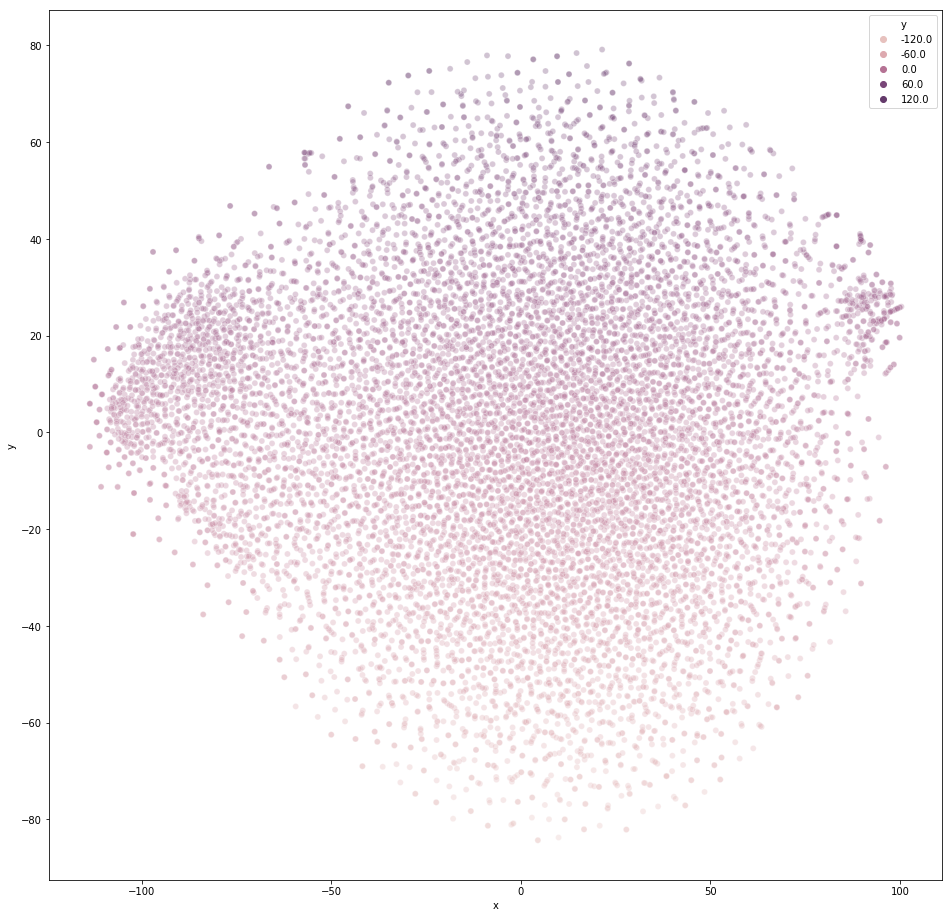

In [268]:
tsne_plot(x,y,labels_lst,-120,120,-100,100,"All_data",-1,"off")

<Figure size 1152x1152 with 0 Axes>

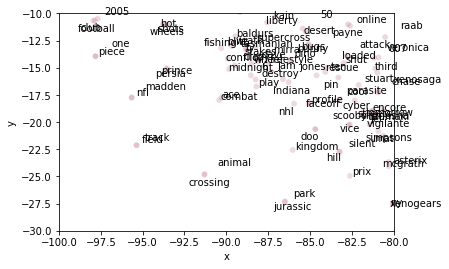

In [269]:
#zoom in some interesting areas
tsne_plot(x,y,labels_lst,-100,-80,-30,-10,"All_data",-1, "on")

<Figure size 1152x1152 with 0 Axes>

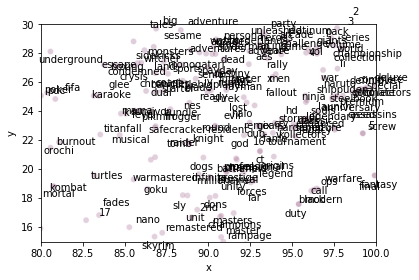

In [271]:
tsne_plot(x,y,labels_lst,80,100,15,30,"All_data",-1, "on")

<Figure size 1152x1152 with 0 Axes>

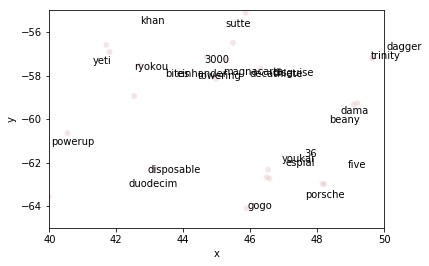

In [272]:
tsne_plot(x,y,labels_lst,40,50,-65,-55,"All_data",-1, "on")

<Figure size 1152x1152 with 0 Axes>

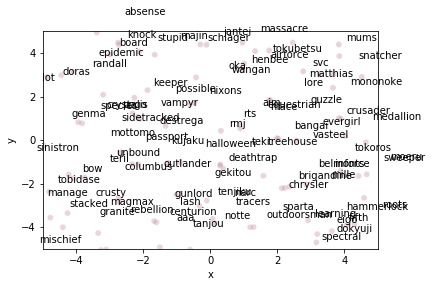

In [275]:
tsne_plot(x,y,labels_lst,-5,5,-5,5,"All_data",-1, "on")

###### tuning

The goal of the this section is to determine the optimal number of epochs and number of word embeddings
parameters tested:
1. no_components =[10,20,50,100]
2. epochs = [100,1000,5000]

The performance is judged by the nearest neighbors of some key words. A more thorough 

In conclusion, the more the number of components and epochs, the more complicated the training is and the longer it takes. 
To balance the time and the information embbed in the vectors, the number of components is set to be 50 with a number of epochs equaling 100.

For more details of the section, please expand the cells.

In [308]:
#Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
#this code is used for hiding/displaying the cell
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


In [278]:
glove_model_dict = {}

In [291]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


#the function will return a dictionary of glovel models that have been trained
def glove_fitting_models(glove_model_dict,learning_rate=0.05,no_components=20,epochs=100,no_threads=4,order=1):
    glove_temp = Glove(no_components, learning_rate)
    glove_temp.fit(corpus.matrix, epochs, no_threads, verbose=True)
    glove_temp.add_dictionary(corpus.dictionary)
    glove_temp.save('glove'+'_'+str(order)+'.model')
    glove_model_dict['glove'+'_'+str(order)] = glove_temp
    return glove_model_dict

In [284]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


order = [1,2,3,4]
no_components_vector = [10,20,50,100]
epochs_num = 1000

#try different number of components
for i in order:
    glove_fitting_models(glove_model_dict,learning_rate=0.01,no_components=no_components_vector[i],epochs=epochs_num,no_threads=4,order=i)

Performing 1000 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epo

Epoch 827
Epoch 828
Epoch 829
Epoch 830
Epoch 831
Epoch 832
Epoch 833
Epoch 834
Epoch 835
Epoch 836
Epoch 837
Epoch 838
Epoch 839
Epoch 840
Epoch 841
Epoch 842
Epoch 843
Epoch 844
Epoch 845
Epoch 846
Epoch 847
Epoch 848
Epoch 849
Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909
Epoch 910
Epoch 911
Epoch 912
Epoch 913
Epoch 914
Epoch 915
Epoch 916
Epoch 917
Epoch 918
Epoch 919
Epoch 920
Epoch 921
Epoch 922
Epoch 923
Epoch 924
Epoch 925
Epoch 926


Epoch 657
Epoch 658
Epoch 659
Epoch 660
Epoch 661
Epoch 662
Epoch 663
Epoch 664
Epoch 665
Epoch 666
Epoch 667
Epoch 668
Epoch 669
Epoch 670
Epoch 671
Epoch 672
Epoch 673
Epoch 674
Epoch 675
Epoch 676
Epoch 677
Epoch 678
Epoch 679
Epoch 680
Epoch 681
Epoch 682
Epoch 683
Epoch 684
Epoch 685
Epoch 686
Epoch 687
Epoch 688
Epoch 689
Epoch 690
Epoch 691
Epoch 692
Epoch 693
Epoch 694
Epoch 695
Epoch 696
Epoch 697
Epoch 698
Epoch 699
Epoch 700
Epoch 701
Epoch 702
Epoch 703
Epoch 704
Epoch 705
Epoch 706
Epoch 707
Epoch 708
Epoch 709
Epoch 710
Epoch 711
Epoch 712
Epoch 713
Epoch 714
Epoch 715
Epoch 716
Epoch 717
Epoch 718
Epoch 719
Epoch 720
Epoch 721
Epoch 722
Epoch 723
Epoch 724
Epoch 725
Epoch 726
Epoch 727
Epoch 728
Epoch 729
Epoch 730
Epoch 731
Epoch 732
Epoch 733
Epoch 734
Epoch 735
Epoch 736
Epoch 737
Epoch 738
Epoch 739
Epoch 740
Epoch 741
Epoch 742
Epoch 743
Epoch 744
Epoch 745
Epoch 746
Epoch 747
Epoch 748
Epoch 749
Epoch 750
Epoch 751
Epoch 752
Epoch 753
Epoch 754
Epoch 755
Epoch 756


Epoch 486
Epoch 487
Epoch 488
Epoch 489
Epoch 490
Epoch 491
Epoch 492
Epoch 493
Epoch 494
Epoch 495
Epoch 496
Epoch 497
Epoch 498
Epoch 499
Epoch 500
Epoch 501
Epoch 502
Epoch 503
Epoch 504
Epoch 505
Epoch 506
Epoch 507
Epoch 508
Epoch 509
Epoch 510
Epoch 511
Epoch 512
Epoch 513
Epoch 514
Epoch 515
Epoch 516
Epoch 517
Epoch 518
Epoch 519
Epoch 520
Epoch 521
Epoch 522
Epoch 523
Epoch 524
Epoch 525
Epoch 526
Epoch 527
Epoch 528
Epoch 529
Epoch 530
Epoch 531
Epoch 532
Epoch 533
Epoch 534
Epoch 535
Epoch 536
Epoch 537
Epoch 538
Epoch 539
Epoch 540
Epoch 541
Epoch 542
Epoch 543
Epoch 544
Epoch 545
Epoch 546
Epoch 547
Epoch 548
Epoch 549
Epoch 550
Epoch 551
Epoch 552
Epoch 553
Epoch 554
Epoch 555
Epoch 556
Epoch 557
Epoch 558
Epoch 559
Epoch 560
Epoch 561
Epoch 562
Epoch 563
Epoch 564
Epoch 565
Epoch 566
Epoch 567
Epoch 568
Epoch 569
Epoch 570
Epoch 571
Epoch 572
Epoch 573
Epoch 574
Epoch 575
Epoch 576
Epoch 577
Epoch 578
Epoch 579
Epoch 580
Epoch 581
Epoch 582
Epoch 583
Epoch 584
Epoch 585


IndexError: list index out of range

In [292]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)
glove_model_dict
x_glove_2,y_glove_2,labels_lst_glove_2 = tsne_transform(glove_model_dict['glove_2'])

{'glove_1': <glove.glove.Glove at 0x25a8108afd0>,
 'glove_2': <glove.glove.Glove at 0x25a8108aa90>,
 'glove_3': <glove.glove.Glove at 0x25a8108a9b0>}

In [286]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)
x_glove_2,y_glove_2,labels_lst_glove_2 = tsne_transform(glove_model_dict['glove_2'])

In [287]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


size_glove_2 = len(labels_lst_glove_2)
size_glove_2 

10934

#### Show the plots

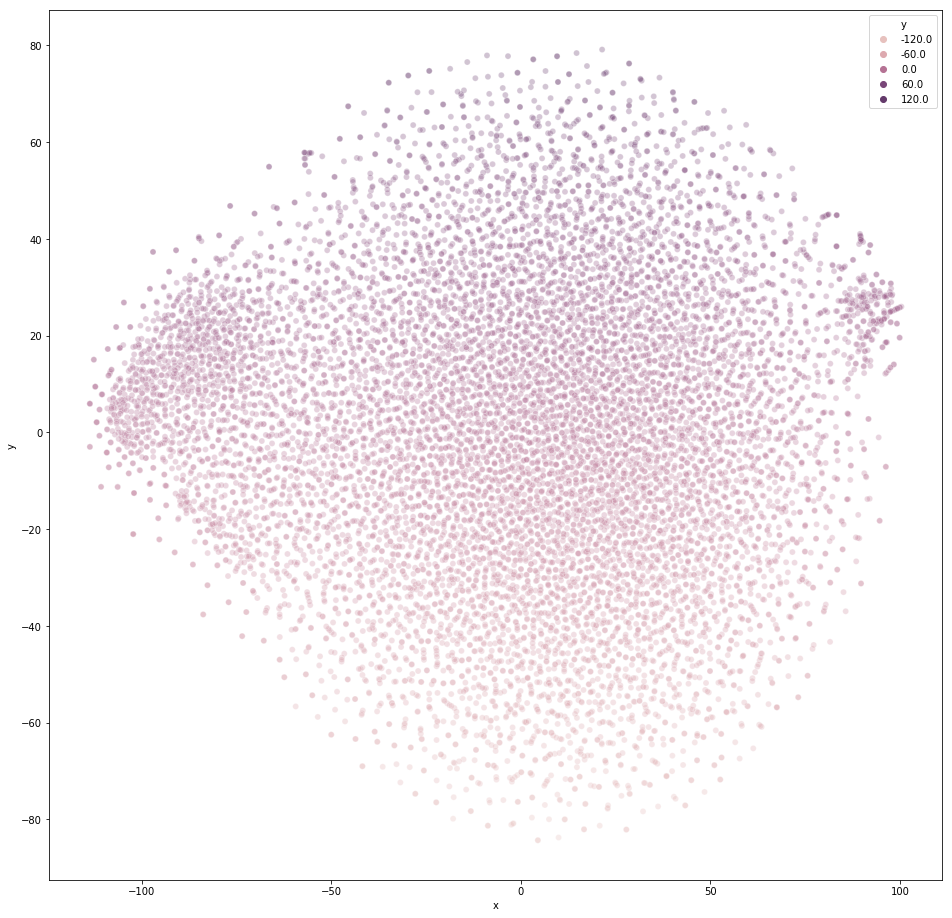

In [288]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,-100,100,-100,100,"All_data",size_glove_2,"off")

In [ ]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,-100,100,-100,100,"All_data",300,"off")

##### Zoom

<Figure size 1152x1152 with 0 Axes>

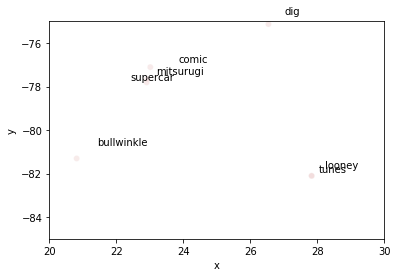

In [289]:
tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,50,60,-85,-75,"All_data",-1,"on")

<Figure size 1152x1152 with 0 Axes>

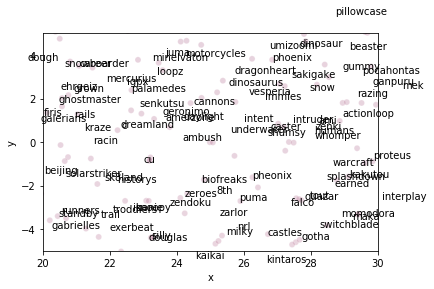

In [293]:
tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,20,30,-5,5,"All_data",-1,"on")

In [ ]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


tsne_plot(x_glove_2,y_glove_2,labels_lst_glove_2,-35,-25,-65,-55,"All_data",-1,"on")

In [294]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


glove_model_dict_2 = {}
order2 = [5,6,7,8]
#try different number of components
for i in order2:
    glove_fitting_models(glove_model_dict_2,learning_rate=0.05,no_components=no_components_vector[i-4],epochs=5000,no_threads=4,order=i)

Performing 5000 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epo

Epoch 826
Epoch 827
Epoch 828
Epoch 829
Epoch 830
Epoch 831
Epoch 832
Epoch 833
Epoch 834
Epoch 835
Epoch 836
Epoch 837
Epoch 838
Epoch 839
Epoch 840
Epoch 841
Epoch 842
Epoch 843
Epoch 844
Epoch 845
Epoch 846
Epoch 847
Epoch 848
Epoch 849
Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909
Epoch 910
Epoch 911
Epoch 912
Epoch 913
Epoch 914
Epoch 915
Epoch 916
Epoch 917
Epoch 918
Epoch 919
Epoch 920
Epoch 921
Epoch 922
Epoch 923
Epoch 924
Epoch 925


Epoch 1592
Epoch 1593
Epoch 1594
Epoch 1595
Epoch 1596
Epoch 1597
Epoch 1598
Epoch 1599
Epoch 1600
Epoch 1601
Epoch 1602
Epoch 1603
Epoch 1604
Epoch 1605
Epoch 1606
Epoch 1607
Epoch 1608
Epoch 1609
Epoch 1610
Epoch 1611
Epoch 1612
Epoch 1613
Epoch 1614
Epoch 1615
Epoch 1616
Epoch 1617
Epoch 1618
Epoch 1619
Epoch 1620
Epoch 1621
Epoch 1622
Epoch 1623
Epoch 1624
Epoch 1625
Epoch 1626
Epoch 1627
Epoch 1628
Epoch 1629
Epoch 1630
Epoch 1631
Epoch 1632
Epoch 1633
Epoch 1634
Epoch 1635
Epoch 1636
Epoch 1637
Epoch 1638
Epoch 1639
Epoch 1640
Epoch 1641
Epoch 1642
Epoch 1643
Epoch 1644
Epoch 1645
Epoch 1646
Epoch 1647
Epoch 1648
Epoch 1649
Epoch 1650
Epoch 1651
Epoch 1652
Epoch 1653
Epoch 1654
Epoch 1655
Epoch 1656
Epoch 1657
Epoch 1658
Epoch 1659
Epoch 1660
Epoch 1661
Epoch 1662
Epoch 1663
Epoch 1664
Epoch 1665
Epoch 1666
Epoch 1667
Epoch 1668
Epoch 1669
Epoch 1670
Epoch 1671
Epoch 1672
Epoch 1673
Epoch 1674
Epoch 1675
Epoch 1676
Epoch 1677
Epoch 1678
Epoch 1679
Epoch 1680
Epoch 1681
Epoch 1682

Epoch 2344
Epoch 2345
Epoch 2346
Epoch 2347
Epoch 2348
Epoch 2349
Epoch 2350
Epoch 2351
Epoch 2352
Epoch 2353
Epoch 2354
Epoch 2355
Epoch 2356
Epoch 2357
Epoch 2358
Epoch 2359
Epoch 2360
Epoch 2361
Epoch 2362
Epoch 2363
Epoch 2364
Epoch 2365
Epoch 2366
Epoch 2367
Epoch 2368
Epoch 2369
Epoch 2370
Epoch 2371
Epoch 2372
Epoch 2373
Epoch 2374
Epoch 2375
Epoch 2376
Epoch 2377
Epoch 2378
Epoch 2379
Epoch 2380
Epoch 2381
Epoch 2382
Epoch 2383
Epoch 2384
Epoch 2385
Epoch 2386
Epoch 2387
Epoch 2388
Epoch 2389
Epoch 2390
Epoch 2391
Epoch 2392
Epoch 2393
Epoch 2394
Epoch 2395
Epoch 2396
Epoch 2397
Epoch 2398
Epoch 2399
Epoch 2400
Epoch 2401
Epoch 2402
Epoch 2403
Epoch 2404
Epoch 2405
Epoch 2406
Epoch 2407
Epoch 2408
Epoch 2409
Epoch 2410
Epoch 2411
Epoch 2412
Epoch 2413
Epoch 2414
Epoch 2415
Epoch 2416
Epoch 2417
Epoch 2418
Epoch 2419
Epoch 2420
Epoch 2421
Epoch 2422
Epoch 2423
Epoch 2424
Epoch 2425
Epoch 2426
Epoch 2427
Epoch 2428
Epoch 2429
Epoch 2430
Epoch 2431
Epoch 2432
Epoch 2433
Epoch 2434

Epoch 3091
Epoch 3092
Epoch 3093
Epoch 3094
Epoch 3095
Epoch 3096
Epoch 3097
Epoch 3098
Epoch 3099
Epoch 3100
Epoch 3101
Epoch 3102
Epoch 3103
Epoch 3104
Epoch 3105
Epoch 3106
Epoch 3107
Epoch 3108
Epoch 3109
Epoch 3110
Epoch 3111
Epoch 3112
Epoch 3113
Epoch 3114
Epoch 3115
Epoch 3116
Epoch 3117
Epoch 3118
Epoch 3119
Epoch 3120
Epoch 3121
Epoch 3122
Epoch 3123
Epoch 3124
Epoch 3125
Epoch 3126
Epoch 3127
Epoch 3128
Epoch 3129
Epoch 3130
Epoch 3131
Epoch 3132
Epoch 3133
Epoch 3134
Epoch 3135
Epoch 3136
Epoch 3137
Epoch 3138
Epoch 3139
Epoch 3140
Epoch 3141
Epoch 3142
Epoch 3143
Epoch 3144
Epoch 3145
Epoch 3146
Epoch 3147
Epoch 3148
Epoch 3149
Epoch 3150
Epoch 3151
Epoch 3152
Epoch 3153
Epoch 3154
Epoch 3155
Epoch 3156
Epoch 3157
Epoch 3158
Epoch 3159
Epoch 3160
Epoch 3161
Epoch 3162
Epoch 3163
Epoch 3164
Epoch 3165
Epoch 3166
Epoch 3167
Epoch 3168
Epoch 3169
Epoch 3170
Epoch 3171
Epoch 3172
Epoch 3173
Epoch 3174
Epoch 3175
Epoch 3176
Epoch 3177
Epoch 3178
Epoch 3179
Epoch 3180
Epoch 3181

Epoch 3839
Epoch 3840
Epoch 3841
Epoch 3842
Epoch 3843
Epoch 3844
Epoch 3845
Epoch 3846
Epoch 3847
Epoch 3848
Epoch 3849
Epoch 3850
Epoch 3851
Epoch 3852
Epoch 3853
Epoch 3854
Epoch 3855
Epoch 3856
Epoch 3857
Epoch 3858
Epoch 3859
Epoch 3860
Epoch 3861
Epoch 3862
Epoch 3863
Epoch 3864
Epoch 3865
Epoch 3866
Epoch 3867
Epoch 3868
Epoch 3869
Epoch 3870
Epoch 3871
Epoch 3872
Epoch 3873
Epoch 3874
Epoch 3875
Epoch 3876
Epoch 3877
Epoch 3878
Epoch 3879
Epoch 3880
Epoch 3881
Epoch 3882
Epoch 3883
Epoch 3884
Epoch 3885
Epoch 3886
Epoch 3887
Epoch 3888
Epoch 3889
Epoch 3890
Epoch 3891
Epoch 3892
Epoch 3893
Epoch 3894
Epoch 3895
Epoch 3896
Epoch 3897
Epoch 3898
Epoch 3899
Epoch 3900
Epoch 3901
Epoch 3902
Epoch 3903
Epoch 3904
Epoch 3905
Epoch 3906
Epoch 3907
Epoch 3908
Epoch 3909
Epoch 3910
Epoch 3911
Epoch 3912
Epoch 3913
Epoch 3914
Epoch 3915
Epoch 3916
Epoch 3917
Epoch 3918
Epoch 3919
Epoch 3920
Epoch 3921
Epoch 3922
Epoch 3923
Epoch 3924
Epoch 3925
Epoch 3926
Epoch 3927
Epoch 3928
Epoch 3929

Epoch 4591
Epoch 4592
Epoch 4593
Epoch 4594
Epoch 4595
Epoch 4596
Epoch 4597
Epoch 4598
Epoch 4599
Epoch 4600
Epoch 4601
Epoch 4602
Epoch 4603
Epoch 4604
Epoch 4605
Epoch 4606
Epoch 4607
Epoch 4608
Epoch 4609
Epoch 4610
Epoch 4611
Epoch 4612
Epoch 4613
Epoch 4614
Epoch 4615
Epoch 4616
Epoch 4617
Epoch 4618
Epoch 4619
Epoch 4620
Epoch 4621
Epoch 4622
Epoch 4623
Epoch 4624
Epoch 4625
Epoch 4626
Epoch 4627
Epoch 4628
Epoch 4629
Epoch 4630
Epoch 4631
Epoch 4632
Epoch 4633
Epoch 4634
Epoch 4635
Epoch 4636
Epoch 4637
Epoch 4638
Epoch 4639
Epoch 4640
Epoch 4641
Epoch 4642
Epoch 4643
Epoch 4644
Epoch 4645
Epoch 4646
Epoch 4647
Epoch 4648
Epoch 4649
Epoch 4650
Epoch 4651
Epoch 4652
Epoch 4653
Epoch 4654
Epoch 4655
Epoch 4656
Epoch 4657
Epoch 4658
Epoch 4659
Epoch 4660
Epoch 4661
Epoch 4662
Epoch 4663
Epoch 4664
Epoch 4665
Epoch 4666
Epoch 4667
Epoch 4668
Epoch 4669
Epoch 4670
Epoch 4671
Epoch 4672
Epoch 4673
Epoch 4674
Epoch 4675
Epoch 4676
Epoch 4677
Epoch 4678
Epoch 4679
Epoch 4680
Epoch 4681

Epoch 378
Epoch 379
Epoch 380
Epoch 381
Epoch 382
Epoch 383
Epoch 384
Epoch 385
Epoch 386
Epoch 387
Epoch 388
Epoch 389
Epoch 390
Epoch 391
Epoch 392
Epoch 393
Epoch 394
Epoch 395
Epoch 396
Epoch 397
Epoch 398
Epoch 399
Epoch 400
Epoch 401
Epoch 402
Epoch 403
Epoch 404
Epoch 405
Epoch 406
Epoch 407
Epoch 408
Epoch 409
Epoch 410
Epoch 411
Epoch 412
Epoch 413
Epoch 414
Epoch 415
Epoch 416
Epoch 417
Epoch 418
Epoch 419
Epoch 420
Epoch 421
Epoch 422
Epoch 423
Epoch 424
Epoch 425
Epoch 426
Epoch 427
Epoch 428
Epoch 429
Epoch 430
Epoch 431
Epoch 432
Epoch 433
Epoch 434
Epoch 435
Epoch 436
Epoch 437
Epoch 438
Epoch 439
Epoch 440
Epoch 441
Epoch 442
Epoch 443
Epoch 444
Epoch 445
Epoch 446
Epoch 447
Epoch 448
Epoch 449
Epoch 450
Epoch 451
Epoch 452
Epoch 453
Epoch 454
Epoch 455
Epoch 456
Epoch 457
Epoch 458
Epoch 459
Epoch 460
Epoch 461
Epoch 462
Epoch 463
Epoch 464
Epoch 465
Epoch 466
Epoch 467
Epoch 468
Epoch 469
Epoch 470
Epoch 471
Epoch 472
Epoch 473
Epoch 474
Epoch 475
Epoch 476
Epoch 477


Epoch 1181
Epoch 1182
Epoch 1183
Epoch 1184
Epoch 1185
Epoch 1186
Epoch 1187
Epoch 1188
Epoch 1189
Epoch 1190
Epoch 1191
Epoch 1192
Epoch 1193
Epoch 1194
Epoch 1195
Epoch 1196
Epoch 1197
Epoch 1198
Epoch 1199
Epoch 1200
Epoch 1201
Epoch 1202
Epoch 1203
Epoch 1204
Epoch 1205
Epoch 1206
Epoch 1207
Epoch 1208
Epoch 1209
Epoch 1210
Epoch 1211
Epoch 1212
Epoch 1213
Epoch 1214
Epoch 1215
Epoch 1216
Epoch 1217
Epoch 1218
Epoch 1219
Epoch 1220
Epoch 1221
Epoch 1222
Epoch 1223
Epoch 1224
Epoch 1225
Epoch 1226
Epoch 1227
Epoch 1228
Epoch 1229
Epoch 1230
Epoch 1231
Epoch 1232
Epoch 1233
Epoch 1234
Epoch 1235
Epoch 1236
Epoch 1237
Epoch 1238
Epoch 1239
Epoch 1240
Epoch 1241
Epoch 1242
Epoch 1243
Epoch 1244
Epoch 1245
Epoch 1246
Epoch 1247
Epoch 1248
Epoch 1249
Epoch 1250
Epoch 1251
Epoch 1252
Epoch 1253
Epoch 1254
Epoch 1255
Epoch 1256
Epoch 1257
Epoch 1258
Epoch 1259
Epoch 1260
Epoch 1261
Epoch 1262
Epoch 1263
Epoch 1264
Epoch 1265
Epoch 1266
Epoch 1267
Epoch 1268
Epoch 1269
Epoch 1270
Epoch 1271

Epoch 1926
Epoch 1927
Epoch 1928
Epoch 1929
Epoch 1930
Epoch 1931
Epoch 1932
Epoch 1933
Epoch 1934
Epoch 1935
Epoch 1936
Epoch 1937
Epoch 1938
Epoch 1939
Epoch 1940
Epoch 1941
Epoch 1942
Epoch 1943
Epoch 1944
Epoch 1945
Epoch 1946
Epoch 1947
Epoch 1948
Epoch 1949
Epoch 1950
Epoch 1951
Epoch 1952
Epoch 1953
Epoch 1954
Epoch 1955
Epoch 1956
Epoch 1957
Epoch 1958
Epoch 1959
Epoch 1960
Epoch 1961
Epoch 1962
Epoch 1963
Epoch 1964
Epoch 1965
Epoch 1966
Epoch 1967
Epoch 1968
Epoch 1969
Epoch 1970
Epoch 1971
Epoch 1972
Epoch 1973
Epoch 1974
Epoch 1975
Epoch 1976
Epoch 1977
Epoch 1978
Epoch 1979
Epoch 1980
Epoch 1981
Epoch 1982
Epoch 1983
Epoch 1984
Epoch 1985
Epoch 1986
Epoch 1987
Epoch 1988
Epoch 1989
Epoch 1990
Epoch 1991
Epoch 1992
Epoch 1993
Epoch 1994
Epoch 1995
Epoch 1996
Epoch 1997
Epoch 1998
Epoch 1999
Epoch 2000
Epoch 2001
Epoch 2002
Epoch 2003
Epoch 2004
Epoch 2005
Epoch 2006
Epoch 2007
Epoch 2008
Epoch 2009
Epoch 2010
Epoch 2011
Epoch 2012
Epoch 2013
Epoch 2014
Epoch 2015
Epoch 2016

Epoch 2673
Epoch 2674
Epoch 2675
Epoch 2676
Epoch 2677
Epoch 2678
Epoch 2679
Epoch 2680
Epoch 2681
Epoch 2682
Epoch 2683
Epoch 2684
Epoch 2685
Epoch 2686
Epoch 2687
Epoch 2688
Epoch 2689
Epoch 2690
Epoch 2691
Epoch 2692
Epoch 2693
Epoch 2694
Epoch 2695
Epoch 2696
Epoch 2697
Epoch 2698
Epoch 2699
Epoch 2700
Epoch 2701
Epoch 2702
Epoch 2703
Epoch 2704
Epoch 2705
Epoch 2706
Epoch 2707
Epoch 2708
Epoch 2709
Epoch 2710
Epoch 2711
Epoch 2712
Epoch 2713
Epoch 2714
Epoch 2715
Epoch 2716
Epoch 2717
Epoch 2718
Epoch 2719
Epoch 2720
Epoch 2721
Epoch 2722
Epoch 2723
Epoch 2724
Epoch 2725
Epoch 2726
Epoch 2727
Epoch 2728
Epoch 2729
Epoch 2730
Epoch 2731
Epoch 2732
Epoch 2733
Epoch 2734
Epoch 2735
Epoch 2736
Epoch 2737
Epoch 2738
Epoch 2739
Epoch 2740
Epoch 2741
Epoch 2742
Epoch 2743
Epoch 2744
Epoch 2745
Epoch 2746
Epoch 2747
Epoch 2748
Epoch 2749
Epoch 2750
Epoch 2751
Epoch 2752
Epoch 2753
Epoch 2754
Epoch 2755
Epoch 2756
Epoch 2757
Epoch 2758
Epoch 2759
Epoch 2760
Epoch 2761
Epoch 2762
Epoch 2763

Epoch 3418
Epoch 3419
Epoch 3420
Epoch 3421
Epoch 3422
Epoch 3423
Epoch 3424
Epoch 3425
Epoch 3426
Epoch 3427
Epoch 3428
Epoch 3429
Epoch 3430
Epoch 3431
Epoch 3432
Epoch 3433
Epoch 3434
Epoch 3435
Epoch 3436
Epoch 3437
Epoch 3438
Epoch 3439
Epoch 3440
Epoch 3441
Epoch 3442
Epoch 3443
Epoch 3444
Epoch 3445
Epoch 3446
Epoch 3447
Epoch 3448
Epoch 3449
Epoch 3450
Epoch 3451
Epoch 3452
Epoch 3453
Epoch 3454
Epoch 3455
Epoch 3456
Epoch 3457
Epoch 3458
Epoch 3459
Epoch 3460
Epoch 3461
Epoch 3462
Epoch 3463
Epoch 3464
Epoch 3465
Epoch 3466
Epoch 3467
Epoch 3468
Epoch 3469
Epoch 3470
Epoch 3471
Epoch 3472
Epoch 3473
Epoch 3474
Epoch 3475
Epoch 3476
Epoch 3477
Epoch 3478
Epoch 3479
Epoch 3480
Epoch 3481
Epoch 3482
Epoch 3483
Epoch 3484
Epoch 3485
Epoch 3486
Epoch 3487
Epoch 3488
Epoch 3489
Epoch 3490
Epoch 3491
Epoch 3492
Epoch 3493
Epoch 3494
Epoch 3495
Epoch 3496
Epoch 3497
Epoch 3498
Epoch 3499
Epoch 3500
Epoch 3501
Epoch 3502
Epoch 3503
Epoch 3504
Epoch 3505
Epoch 3506
Epoch 3507
Epoch 3508

Epoch 4164
Epoch 4165
Epoch 4166
Epoch 4167
Epoch 4168
Epoch 4169
Epoch 4170
Epoch 4171
Epoch 4172
Epoch 4173
Epoch 4174
Epoch 4175
Epoch 4176
Epoch 4177
Epoch 4178
Epoch 4179
Epoch 4180
Epoch 4181
Epoch 4182
Epoch 4183
Epoch 4184
Epoch 4185
Epoch 4186
Epoch 4187
Epoch 4188
Epoch 4189
Epoch 4190
Epoch 4191
Epoch 4192
Epoch 4193
Epoch 4194
Epoch 4195
Epoch 4196
Epoch 4197
Epoch 4198
Epoch 4199
Epoch 4200
Epoch 4201
Epoch 4202
Epoch 4203
Epoch 4204
Epoch 4205
Epoch 4206
Epoch 4207
Epoch 4208
Epoch 4209
Epoch 4210
Epoch 4211
Epoch 4212
Epoch 4213
Epoch 4214
Epoch 4215
Epoch 4216
Epoch 4217
Epoch 4218
Epoch 4219
Epoch 4220
Epoch 4221
Epoch 4222
Epoch 4223
Epoch 4224
Epoch 4225
Epoch 4226
Epoch 4227
Epoch 4228
Epoch 4229
Epoch 4230
Epoch 4231
Epoch 4232
Epoch 4233
Epoch 4234
Epoch 4235
Epoch 4236
Epoch 4237
Epoch 4238
Epoch 4239
Epoch 4240
Epoch 4241
Epoch 4242
Epoch 4243
Epoch 4244
Epoch 4245
Epoch 4246
Epoch 4247
Epoch 4248
Epoch 4249
Epoch 4250
Epoch 4251
Epoch 4252
Epoch 4253
Epoch 4254

Epoch 4911
Epoch 4912
Epoch 4913
Epoch 4914
Epoch 4915
Epoch 4916
Epoch 4917
Epoch 4918
Epoch 4919
Epoch 4920
Epoch 4921
Epoch 4922
Epoch 4923
Epoch 4924
Epoch 4925
Epoch 4926
Epoch 4927
Epoch 4928
Epoch 4929
Epoch 4930
Epoch 4931
Epoch 4932
Epoch 4933
Epoch 4934
Epoch 4935
Epoch 4936
Epoch 4937
Epoch 4938
Epoch 4939
Epoch 4940
Epoch 4941
Epoch 4942
Epoch 4943
Epoch 4944
Epoch 4945
Epoch 4946
Epoch 4947
Epoch 4948
Epoch 4949
Epoch 4950
Epoch 4951
Epoch 4952
Epoch 4953
Epoch 4954
Epoch 4955
Epoch 4956
Epoch 4957
Epoch 4958
Epoch 4959
Epoch 4960
Epoch 4961
Epoch 4962
Epoch 4963
Epoch 4964
Epoch 4965
Epoch 4966
Epoch 4967
Epoch 4968
Epoch 4969
Epoch 4970
Epoch 4971
Epoch 4972
Epoch 4973
Epoch 4974
Epoch 4975
Epoch 4976
Epoch 4977
Epoch 4978
Epoch 4979
Epoch 4980
Epoch 4981
Epoch 4982
Epoch 4983
Epoch 4984
Epoch 4985
Epoch 4986
Epoch 4987
Epoch 4988
Epoch 4989
Epoch 4990
Epoch 4991
Epoch 4992
Epoch 4993
Epoch 4994
Epoch 4995
Epoch 4996
Epoch 4997
Epoch 4998
Epoch 4999
Performing 5000 train

Epoch 730
Epoch 731
Epoch 732
Epoch 733
Epoch 734
Epoch 735
Epoch 736
Epoch 737
Epoch 738
Epoch 739
Epoch 740
Epoch 741
Epoch 742
Epoch 743
Epoch 744
Epoch 745
Epoch 746
Epoch 747
Epoch 748
Epoch 749
Epoch 750
Epoch 751
Epoch 752
Epoch 753
Epoch 754
Epoch 755
Epoch 756
Epoch 757
Epoch 758
Epoch 759
Epoch 760
Epoch 761
Epoch 762
Epoch 763
Epoch 764
Epoch 765
Epoch 766
Epoch 767
Epoch 768
Epoch 769
Epoch 770
Epoch 771
Epoch 772
Epoch 773
Epoch 774
Epoch 775
Epoch 776
Epoch 777
Epoch 778
Epoch 779
Epoch 780
Epoch 781
Epoch 782
Epoch 783
Epoch 784
Epoch 785
Epoch 786
Epoch 787
Epoch 788
Epoch 789
Epoch 790
Epoch 791
Epoch 792
Epoch 793
Epoch 794
Epoch 795
Epoch 796
Epoch 797
Epoch 798
Epoch 799
Epoch 800
Epoch 801
Epoch 802
Epoch 803
Epoch 804
Epoch 805
Epoch 806
Epoch 807
Epoch 808
Epoch 809
Epoch 810
Epoch 811
Epoch 812
Epoch 813
Epoch 814
Epoch 815
Epoch 816
Epoch 817
Epoch 818
Epoch 819
Epoch 820
Epoch 821
Epoch 822
Epoch 823
Epoch 824
Epoch 825
Epoch 826
Epoch 827
Epoch 828
Epoch 829


Epoch 1500
Epoch 1501
Epoch 1502
Epoch 1503
Epoch 1504
Epoch 1505
Epoch 1506
Epoch 1507
Epoch 1508
Epoch 1509
Epoch 1510
Epoch 1511
Epoch 1512
Epoch 1513
Epoch 1514
Epoch 1515
Epoch 1516
Epoch 1517
Epoch 1518
Epoch 1519
Epoch 1520
Epoch 1521
Epoch 1522
Epoch 1523
Epoch 1524
Epoch 1525
Epoch 1526
Epoch 1527
Epoch 1528
Epoch 1529
Epoch 1530
Epoch 1531
Epoch 1532
Epoch 1533
Epoch 1534
Epoch 1535
Epoch 1536
Epoch 1537
Epoch 1538
Epoch 1539
Epoch 1540
Epoch 1541
Epoch 1542
Epoch 1543
Epoch 1544
Epoch 1545
Epoch 1546
Epoch 1547
Epoch 1548
Epoch 1549
Epoch 1550
Epoch 1551
Epoch 1552
Epoch 1553
Epoch 1554
Epoch 1555
Epoch 1556
Epoch 1557
Epoch 1558
Epoch 1559
Epoch 1560
Epoch 1561
Epoch 1562
Epoch 1563
Epoch 1564
Epoch 1565
Epoch 1566
Epoch 1567
Epoch 1568
Epoch 1569
Epoch 1570
Epoch 1571
Epoch 1572
Epoch 1573
Epoch 1574
Epoch 1575
Epoch 1576
Epoch 1577
Epoch 1578
Epoch 1579
Epoch 1580
Epoch 1581
Epoch 1582
Epoch 1583
Epoch 1584
Epoch 1585
Epoch 1586
Epoch 1587
Epoch 1588
Epoch 1589
Epoch 1590

Epoch 2248
Epoch 2249
Epoch 2250
Epoch 2251
Epoch 2252
Epoch 2253
Epoch 2254
Epoch 2255
Epoch 2256
Epoch 2257
Epoch 2258
Epoch 2259
Epoch 2260
Epoch 2261
Epoch 2262
Epoch 2263
Epoch 2264
Epoch 2265
Epoch 2266
Epoch 2267
Epoch 2268
Epoch 2269
Epoch 2270
Epoch 2271
Epoch 2272
Epoch 2273
Epoch 2274
Epoch 2275
Epoch 2276
Epoch 2277
Epoch 2278
Epoch 2279
Epoch 2280
Epoch 2281
Epoch 2282
Epoch 2283
Epoch 2284
Epoch 2285
Epoch 2286
Epoch 2287
Epoch 2288
Epoch 2289
Epoch 2290
Epoch 2291
Epoch 2292
Epoch 2293
Epoch 2294
Epoch 2295
Epoch 2296
Epoch 2297
Epoch 2298
Epoch 2299
Epoch 2300
Epoch 2301
Epoch 2302
Epoch 2303
Epoch 2304
Epoch 2305
Epoch 2306
Epoch 2307
Epoch 2308
Epoch 2309
Epoch 2310
Epoch 2311
Epoch 2312
Epoch 2313
Epoch 2314
Epoch 2315
Epoch 2316
Epoch 2317
Epoch 2318
Epoch 2319
Epoch 2320
Epoch 2321
Epoch 2322
Epoch 2323
Epoch 2324
Epoch 2325
Epoch 2326
Epoch 2327
Epoch 2328
Epoch 2329
Epoch 2330
Epoch 2331
Epoch 2332
Epoch 2333
Epoch 2334
Epoch 2335
Epoch 2336
Epoch 2337
Epoch 2338

Epoch 2995
Epoch 2996
Epoch 2997
Epoch 2998
Epoch 2999
Epoch 3000
Epoch 3001
Epoch 3002
Epoch 3003
Epoch 3004
Epoch 3005
Epoch 3006
Epoch 3007
Epoch 3008
Epoch 3009
Epoch 3010
Epoch 3011
Epoch 3012
Epoch 3013
Epoch 3014
Epoch 3015
Epoch 3016
Epoch 3017
Epoch 3018
Epoch 3019
Epoch 3020
Epoch 3021
Epoch 3022
Epoch 3023
Epoch 3024
Epoch 3025
Epoch 3026
Epoch 3027
Epoch 3028
Epoch 3029
Epoch 3030
Epoch 3031
Epoch 3032
Epoch 3033
Epoch 3034
Epoch 3035
Epoch 3036
Epoch 3037
Epoch 3038
Epoch 3039
Epoch 3040
Epoch 3041
Epoch 3042
Epoch 3043
Epoch 3044
Epoch 3045
Epoch 3046
Epoch 3047
Epoch 3048
Epoch 3049
Epoch 3050
Epoch 3051
Epoch 3052
Epoch 3053
Epoch 3054
Epoch 3055
Epoch 3056
Epoch 3057
Epoch 3058
Epoch 3059
Epoch 3060
Epoch 3061
Epoch 3062
Epoch 3063
Epoch 3064
Epoch 3065
Epoch 3066
Epoch 3067
Epoch 3068
Epoch 3069
Epoch 3070
Epoch 3071
Epoch 3072
Epoch 3073
Epoch 3074
Epoch 3075
Epoch 3076
Epoch 3077
Epoch 3078
Epoch 3079
Epoch 3080
Epoch 3081
Epoch 3082
Epoch 3083
Epoch 3084
Epoch 3085

Epoch 3742
Epoch 3743
Epoch 3744
Epoch 3745
Epoch 3746
Epoch 3747
Epoch 3748
Epoch 3749
Epoch 3750
Epoch 3751
Epoch 3752
Epoch 3753
Epoch 3754
Epoch 3755
Epoch 3756
Epoch 3757
Epoch 3758
Epoch 3759
Epoch 3760
Epoch 3761
Epoch 3762
Epoch 3763
Epoch 3764
Epoch 3765
Epoch 3766
Epoch 3767
Epoch 3768
Epoch 3769
Epoch 3770
Epoch 3771
Epoch 3772
Epoch 3773
Epoch 3774
Epoch 3775
Epoch 3776
Epoch 3777
Epoch 3778
Epoch 3779
Epoch 3780
Epoch 3781
Epoch 3782
Epoch 3783
Epoch 3784
Epoch 3785
Epoch 3786
Epoch 3787
Epoch 3788
Epoch 3789
Epoch 3790
Epoch 3791
Epoch 3792
Epoch 3793
Epoch 3794
Epoch 3795
Epoch 3796
Epoch 3797
Epoch 3798
Epoch 3799
Epoch 3800
Epoch 3801
Epoch 3802
Epoch 3803
Epoch 3804
Epoch 3805
Epoch 3806
Epoch 3807
Epoch 3808
Epoch 3809
Epoch 3810
Epoch 3811
Epoch 3812
Epoch 3813
Epoch 3814
Epoch 3815
Epoch 3816
Epoch 3817
Epoch 3818
Epoch 3819
Epoch 3820
Epoch 3821
Epoch 3822
Epoch 3823
Epoch 3824
Epoch 3825
Epoch 3826
Epoch 3827
Epoch 3828
Epoch 3829
Epoch 3830
Epoch 3831
Epoch 3832

Epoch 4488
Epoch 4489
Epoch 4490
Epoch 4491
Epoch 4492
Epoch 4493
Epoch 4494
Epoch 4495
Epoch 4496
Epoch 4497
Epoch 4498
Epoch 4499
Epoch 4500
Epoch 4501
Epoch 4502
Epoch 4503
Epoch 4504
Epoch 4505
Epoch 4506
Epoch 4507
Epoch 4508
Epoch 4509
Epoch 4510
Epoch 4511
Epoch 4512
Epoch 4513
Epoch 4514
Epoch 4515
Epoch 4516
Epoch 4517
Epoch 4518
Epoch 4519
Epoch 4520
Epoch 4521
Epoch 4522
Epoch 4523
Epoch 4524
Epoch 4525
Epoch 4526
Epoch 4527
Epoch 4528
Epoch 4529
Epoch 4530
Epoch 4531
Epoch 4532
Epoch 4533
Epoch 4534
Epoch 4535
Epoch 4536
Epoch 4537
Epoch 4538
Epoch 4539
Epoch 4540
Epoch 4541
Epoch 4542
Epoch 4543
Epoch 4544
Epoch 4545
Epoch 4546
Epoch 4547
Epoch 4548
Epoch 4549
Epoch 4550
Epoch 4551
Epoch 4552
Epoch 4553
Epoch 4554
Epoch 4555
Epoch 4556
Epoch 4557
Epoch 4558
Epoch 4559
Epoch 4560
Epoch 4561
Epoch 4562
Epoch 4563
Epoch 4564
Epoch 4565
Epoch 4566
Epoch 4567
Epoch 4568
Epoch 4569
Epoch 4570
Epoch 4571
Epoch 4572
Epoch 4573
Epoch 4574
Epoch 4575
Epoch 4576
Epoch 4577
Epoch 4578

IndexError: list index out of range

In [295]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

glove_model_dict_2

{'glove_5': <glove.glove.Glove at 0x25a9e4b8550>,
 'glove_6': <glove.glove.Glove at 0x25aa03ea978>,
 'glove_7': <glove.glove.Glove at 0x25aa03ea0f0>}

In [296]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


x_glove_6,y_glove_6,labels_lst_glove_6 = tsne_transform(glove_model_dict_2['glove_6'])

In [297]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


size_glove_6= len(labels_lst_glove_6)
size_glove_6 

10934

#### Show the plots

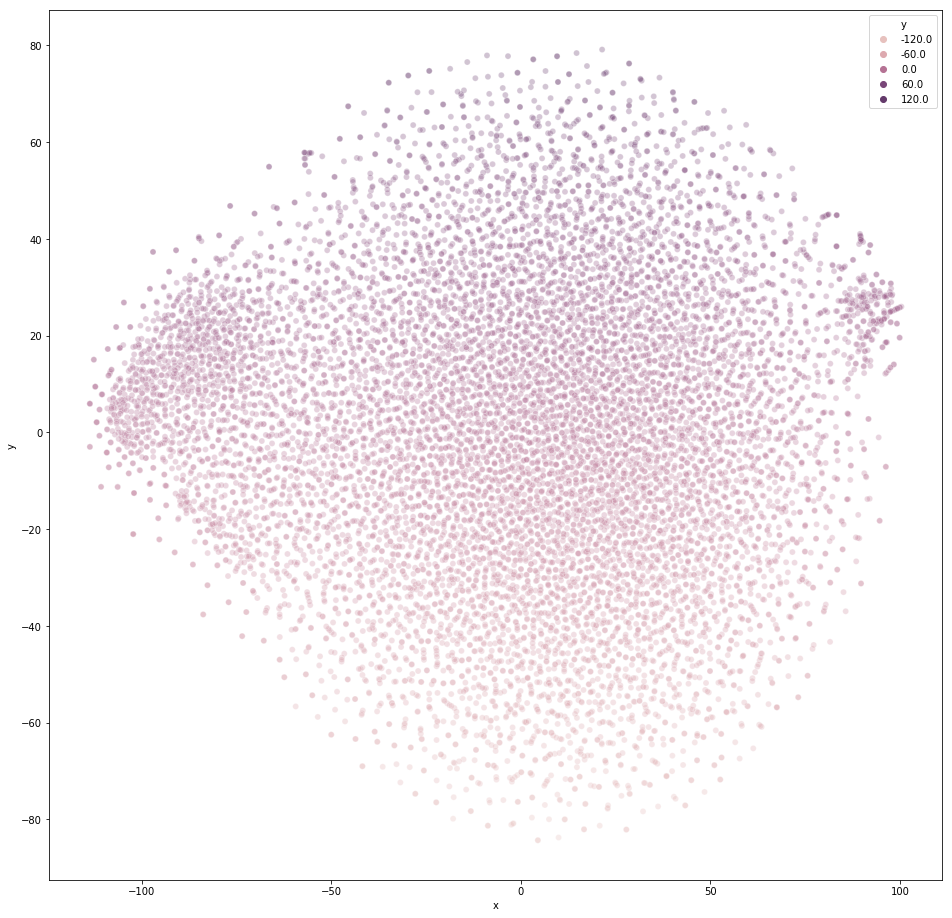

In [298]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


tsne_plot(x_glove_6,y_glove_6,labels_lst_glove_6,-100,100,-100,100,"All_data",size_glove_6,"off")

##### The groups in the graph looks more distinct with epoch = 5000 (the above model was using epoch = 5000 and a word size of 10)

#### With 300 data points:

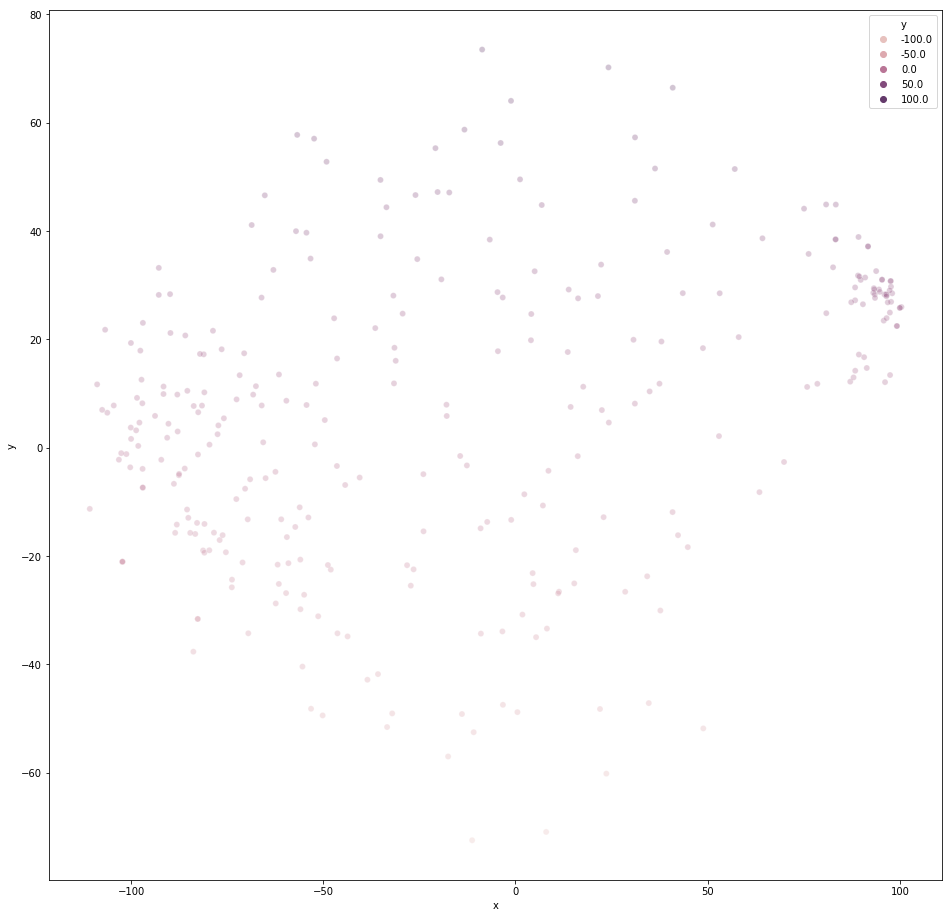

In [299]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


tsne_plot(x_glove_6,y_glove_6,labels_lst_glove_6,-100,100,-100,100,"All_data",300,"off")

##### Details

<Figure size 1152x1152 with 0 Axes>

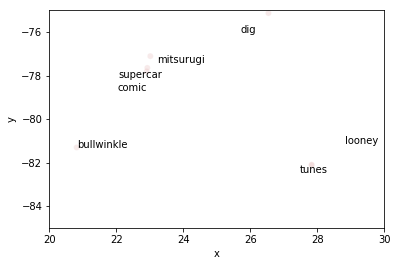

In [301]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


tsne_plot(x_glove_6,y_glove_6,labels_lst_glove_6,20,30,-85,-75,"All_data",-1,"on")

<Figure size 1152x1152 with 0 Axes>

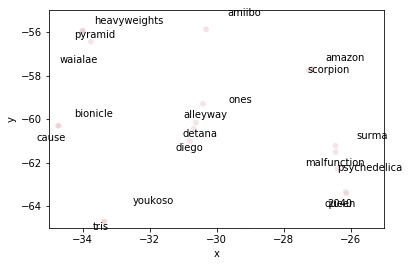

In [302]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


tsne_plot(x_glove_6,y_glove_6,labels_lst_glove_6,-35,-25,-65,-55,"All_data",-1,"on")

##### Looking at the most similar words to the following:
1.james
2.assassins

###### word embedding = 20 and epoch = 5000

In [303]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


#check some key word
#5000 trainings dimention 20
print(glove.word_vectors[glove_model_dict_2['glove_6'].dictionary['james']])
print(glove_model_dict_2['glove_6'].most_similar('james'))
print(glove_model_dict_2['glove_6'].most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('jesse', 0.8872831144624608), ('pond', 0.6090194975969832), ('phantasy', 0.5989426914641991), ('fugitive', 0.5817004985007167)]
[('creed', 0.6246589972382892), ('kitten', 0.5709702075821539), ('parrot', 0.5344696410825592), ('anno', 0.497687034429463)]


###### word embedding = 20 and epoch = 1000

In [304]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


#1000 trainings dimention 20
print(glove.word_vectors[glove_model_dict['glove_2'].dictionary['james']])
print(glove_model_dict['glove_2'].most_similar('james'))
print(glove_model_dict['glove_2'].most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('pond', 0.8891512775335156), ('bond', 0.7628836791370942), ('ufo', 0.7210971733635188), ('zoop', 0.7203082050672449)]
[('creed', 0.9284696812781685), ('unity', 0.8663008942709455), ('origins', 0.6743881996219291), ('tenchu', 0.6217114336512592)]


###### word embedding = 10 and epoch = 1000

In [305]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


#1000 trainings dimention 10
print(glove.word_vectors[glove_model_dict['glove_1'].dictionary['james']])
print(glove_model_dict['glove_1'].most_similar('james'))
print(glove_model_dict['glove_1'].most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('pond', 0.9211753231128268), ('bond', 0.8019054384414325), ('zekkeiban', 0.7590765780819447), ('suimei', 0.7491866922992734)]
[('creed', 0.9639949388965815), ('unity', 0.9227633110654901), ('barnstorming', 0.7778977938213053), ('gamebreaker', 0.7602664243492462)]


###### word embedding = 50 and epoch = 1000

In [306]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


#1000 trainings dimention 50
print(glove.word_vectors[glove_model_dict['glove_3'].dictionary['james']])
print(glove_model_dict['glove_3'].most_similar('james'))
print(glove_model_dict['glove_3'].most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('pond', 0.8884993448243748), ('bond', 0.763340742522813), ('shockwave', 0.6902764293024378), ('ufo', 0.6860765262054005)]
[('creed', 0.9066377120867063), ('unity', 0.781581152524177), ('tenchu', 0.6501596713511026), ('origins', 0.6034974081512561)]


###### word embedding = 20 and epoch = 100

In [307]:
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


#100 trainings dimention 20
print(glove.word_vectors[glove.dictionary['james']])
print(glove.most_similar('james'))
print(glove.most_similar('assassins'))

[ 0.00969021  0.00221471  0.01780448  0.00836456  0.00167293 -0.00227189
 -0.00914827 -0.00121577 -0.01188478 -0.00552771 -0.01924564  0.00364726
 -0.0033934  -0.0008946   0.01006231 -0.00888368 -0.01723945  0.00289619
  0.0022534   0.00833407 -0.01552999  0.00694825  0.00347814  0.01196413
 -0.01477575 -0.01008654 -0.00688206 -0.01555829  0.01357057 -0.00617438
  0.00871928 -0.00489974  0.00446209  0.00397953 -0.00439243  0.00321113
  0.01160974 -0.0080034  -0.00352542 -0.0075956  -0.01746714 -0.00271227
  0.00391657  0.01241669  0.00736378  0.00641597  0.00831864  0.00614372
  0.0083404  -0.00301123]
[('pond', 0.7085986497500207), ('burst', 0.6786504428360346), ('book', 0.6519728864166612), ('reverie', 0.6513098448726607)]
[('creed', 0.9960528033447483), ('origins', 0.9304566378930905), ('legacy', 0.8288224939451014), ('unity', 0.7972232055947592)]


Base on the previous 2 sections, we would expect the word vectors to add some values to the price prediction. However, the value could be improved through a larger number of word embeddings, more epochs or even a bigger corpus.
But fur now we will use a size of 50 and epoch of 100.

##### end of  tuning

The next step is to generate actual vectors to be used in the features

In [310]:
#try first with the vectors from epoch = 100 and dimention 20
#and take the mean of all the words available in the title
sentence_vectors = []
real_vectors = []
embed_n = 50
for each_line in filtered_lines:
    temp = 0
    sum_temp = 0
    if (each_line == 'nan') or (len(each_line) == 0):
        #the vector is 0 if the name is "nan"
        temp = [0]*embed_n
    else:
        #2 vectors are being generated as 2 useful inputs later in the analysis
        #1: mean of the word vectors -> sentence vector
        #2: the word vectors themselves
        temp = np.mean([glove.word_vectors[glove.dictionary[w]] for w in each_line],axis=0)    
        temp_realv = [glove.word_vectors[glove.dictionary[w]] for w in each_line]
    sentence_vectors.append(temp) 
    real_vectors.append(temp_realv)

In [311]:
#save vectors
save_obj(real_vectors,"word_vectors_size50")
save_obj(sentence_vectors,"mean_word_vectors_size50")

In [312]:
#add this into df_new
df_new["glove_vectors"] = sentence_vectors

In [313]:
#save as the second version
df_new.to_pickle("./CleanedData_secondversion.pk1")

##### Create vectors using TF-IDF

In [314]:
#turn filtered lines into a list of sentences with spaces and without stopwords 
key_sentences = []

for x in filtered_lines:
    temp = " ".join(x)
    key_sentences.append(temp)

In [315]:
key_sentences[:5]

['30 great games family party',
 '007 agent fire',
 '007 everything nothing',
 '007 russia love',
 '007 nightfire']

In [316]:
vectorizer = TfidfVectorizer(token_pattern=r'\S+')
weights = vectorizer.fit_transform(key_sentences)

In [317]:
feature_names = vectorizer.get_feature_names()
doc = 2
feature_index = weights[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [weights[doc, x] for x in feature_index])

In [318]:
feature_names[:5]

['0', '001', '007', '0079', '009']

In [319]:
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)

007 0.4809126277743323
everything 0.6271752202904937
nothing 0.6126779639425244


In [321]:
#now get the scores for each line
score_dict = {}
line_dict = {}

total_lines = len(filtered_lines)

for i in range(total_lines):
    line_dict = {}
    feature_index = weights[i,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [weights[i, x] for x in feature_index])
    for w, s in [(feature_names[ii], s) for (ii, s) in tfidf_scores]:
        line_dict[w] = s
    
    #append the score for the line to the total dictionary
    score_dict[i] = line_dict

In [325]:
score_dict[0]

{'30': 0.4862269826481783,
 'great': 0.46833112376457753,
 'games': 0.4113234749802846,
 'family': 0.46357338416187177,
 'party': 0.4002024441268554}

In [326]:
#export and save the dictionary of score
save_obj(score_dict,"tfidf_dict_size50")

In [327]:
len(score_dict)

22921

In [328]:
len(filtered_lines)

22921

In [332]:
total_lines

22921

##### apply tfidf to the sentence vectors as the weight

In [334]:
#score_dict{index:{word:score....word:score....}}
#real_vectors 21219*n*20

tfidf_vector = []
v_sum = 0
s_sum = 0

for i in range(total_lines):
    v_sum = 0
    s_sum = 0
    s_temp = 0
    temp = 0
    n=len(filtered_lines[i])
    if n>0:
        for w in range(n):
            word = filtered_lines[i][w]
            s_temp = score_dict[i][str(word)]
            v_sum = v_sum + real_vectors[i][w] * s_temp
            s_sum = s_sum + s_temp
            temp = v_sum/s_sum
    else:
        temp = 0
    
    tfidf_vector.append(temp)


In [335]:
#save the tfidf adjusted vector
save_obj(tfidf_vector,"tfidf_vector_corpus_size50")

In [336]:
#add tfidf_vector to the dataframe
#add this into df_new
df_new["tfidf_vectors"] =tfidf_vector

In [337]:
#save this new dataset

save_obj(df_new,"df_tfidf_size50")